In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

C:\Users\filip\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [2]:
tf.__version__

'2.0.0'

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [6]:
sys.path.append(os.getcwd())

In [7]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [8]:
full_experiment_data = prepare_experiment()

Dtype: DataType.TRAIN shape: 36532
Dtype: DataType.TEST shape: 21952
Dtype: DataType.VALID shape: 14697
N train ids: 10167
N train val ids: 10168


In [9]:
test_joined = full_experiment_data.Xraw_test.merge(full_experiment_data.Xhidden_test, on=['user_id', 'item_id'], how='inner')
test_joined.head(3)

,user_id,item_id,rating_x,rating_y
0,0,0,2.0,2.0
1,13,24,5.0,0.0
2,24,30,5.0,5.0


In [10]:
ytest = np.expand_dims(full_experiment_data.Xraw_test.rating.to_numpy(), axis=1)

In [11]:
crossvals = list(prepare_crossval_experiment(nsplits=10))

C:\Users\filip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processing cv 0
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 64083
Dtype: DataType.TEST shape: 5454
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65267
Dtype: DataType.TEST shape: 4732
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65928
Dtype: DataType.TEST shape: 4350
Dtype: DataType.VALID shape: 2903
N train ids: 18301
N train val ids: 2034
Processing cv 3
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65835
Dtype: DataType.TEST shape: 4353
Dtype: DataType.VALID shape: 2993
N train ids: 18301
N train val ids: 2034
Processing cv 4
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 66018
Dtype: DataType.TEST shape: 4293
Dtype: DataType.VALID shape: 2870
N train ids: 18301
N 

In [12]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [13]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [14]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [15]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    x_test = [
        exd.Xhidden_test.user_id.to_numpy(dtype='int32'),
        exd.Xhidden_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test.astype('float32')
    ]
    
    return x, y, x_val, y_val, x_test

In [16]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [31]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer=optimizer, metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [32]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 12s 188us/sample - loss: 2.7959 - mse_masked: 2.7955 - mae: 1.2756 - mape_masked: 0.4327 - val_loss: 1.4413 - val_mse_masked: 1.4418 - val_mae: 0.9269 - val_mape_masked: 0.4105
Epoch 2/15
64083/64083 [==============================] - 11s 168us/sample - loss: 1.2329 - mse_masked: 1.2329 - mae: 0.8386 - mape_masked: 0.3572 - val_loss: 1.4097 - val_mse_masked: 1.4103 - val_mae: 0.9224 - val_mape_masked: 0.4026
Epoch 3/15
64083/64083 [==============================] - 11s 167us/sample - loss: 0.9690 - mse_masked: 0.9692 - mae: 0.7316 - mape_masked: 0.3036 - val_loss: 1.4089 - val_mse_masked: 1.4094 - val_mae: 0.9365 - val_mape_masked: 0.3997
Epoch 4/15
64083/64083 [==============================] - 11s 168us/sample - loss: 0.8195 - mse_masked: 0.8195 - mae: 0.6736 - mape_masked: 0.2702 - val_loss: 1.4224 - val_mse_masked: 1.4229 - val_mae: 0.9369 - val_mape_masked: 0.4016
Epoch 5/15


Epoch 5/15
65928/65928 [==============================] - 11s 167us/sample - loss: 0.7404 - mse_masked: 0.7406 - mae: 0.6368 - mape_masked: 0.2519 - val_loss: 1.3765 - val_mse_masked: 1.3772 - val_mae: 0.9294 - val_mape_masked: 0.3861
Epoch 6/15
65928/65928 [==============================] - 11s 166us/sample - loss: 0.6833 - mse_masked: 0.6833 - mae: 0.6066 - mape_masked: 0.2376 - val_loss: 1.3769 - val_mse_masked: 1.3776 - val_mae: 0.9364 - val_mape_masked: 0.3842
Epoch 7/15
65928/65928 [==============================] - 11s 166us/sample - loss: 0.6439 - mse_masked: 0.6438 - mae: 0.5845 - mape_masked: 0.2272 - val_loss: 1.3639 - val_mse_masked: 1.3647 - val_mae: 0.9185 - val_mape_masked: 0.3861
Epoch 8/15
65928/65928 [==============================] - 11s 166us/sample - loss: 0.6237 - mse_masked: 0.6239 - mae: 0.5727 - mape_masked: 0.2223 - val_loss: 1.3753 - val_mse_masked: 1.3761 - val_mae: 0.9278 - val_mape_masked: 0.3861
Epoch 9/15
65928/65928 [==============================] - 11

66018/66018 [==============================] - 11s 163us/sample - loss: 0.6575 - mse_masked: 0.6572 - mae: 0.5918 - mape_masked: 0.2309 - val_loss: 1.3854 - val_mse_masked: 1.3851 - val_mae: 0.9659 - val_mape_masked: 0.3804
Epoch 9/15
66018/66018 [==============================] - 11s 163us/sample - loss: 0.6273 - mse_masked: 0.6271 - mae: 0.5740 - mape_masked: 0.2236 - val_loss: 1.3949 - val_mse_masked: 1.3945 - val_mae: 0.9750 - val_mape_masked: 0.3808
Epoch 10/15
66018/66018 [==============================] - 11s 162us/sample - loss: 0.6094 - mse_masked: 0.6093 - mae: 0.5625 - mape_masked: 0.2192 - val_loss: 1.3681 - val_mse_masked: 1.3677 - val_mae: 0.9473 - val_mape_masked: 0.3808
Epoch 11/15
66018/66018 [==============================] - 11s 162us/sample - loss: 0.6055 - mse_masked: 0.6053 - mae: 0.5594 - mape_masked: 0.2180 - val_loss: 1.3597 - val_mse_masked: 1.3593 - val_mae: 0.9398 - val_mape_masked: 0.3809
Epoch 12/15
66018/66018 [==============================] - 11s 162us/

66100/66100 [==============================] - 11s 166us/sample - loss: 0.5897 - mse_masked: 0.5898 - mae: 0.5479 - mape_masked: 0.2132 - val_loss: 1.2902 - val_mse_masked: 1.2875 - val_mae: 0.9283 - val_mape_masked: 0.3537
Epoch 12/15
66100/66100 [==============================] - 11s 166us/sample - loss: 0.5791 - mse_masked: 0.5791 - mae: 0.5419 - mape_masked: 0.2098 - val_loss: 1.2736 - val_mse_masked: 1.2709 - val_mae: 0.9107 - val_mape_masked: 0.3543
Epoch 13/15
66100/66100 [==============================] - 11s 165us/sample - loss: 0.5748 - mse_masked: 0.5748 - mae: 0.5366 - mape_masked: 0.2091 - val_loss: 1.2795 - val_mse_masked: 1.2769 - val_mae: 0.9150 - val_mape_masked: 0.3550
Epoch 14/15
66100/66100 [==============================] - 11s 166us/sample - loss: 0.5691 - mse_masked: 0.5691 - mae: 0.5319 - mape_masked: 0.2072 - val_loss: 1.2793 - val_mse_masked: 1.2767 - val_mae: 0.9140 - val_mape_masked: 0.3555
Epoch 15/15
66100/66100 [==============================] - 11s 166us

Epoch 14/15
66408/66408 [==============================] - 11s 167us/sample - loss: 0.5703 - mse_masked: 0.5710 - mae: 0.5343 - mape_masked: 0.2075 - val_loss: 1.4123 - val_mse_masked: 1.4168 - val_mae: 0.9571 - val_mape_masked: 0.4003
Epoch 15/15
66408/66408 [==============================] - 11s 166us/sample - loss: 0.5738 - mse_masked: 0.5737 - mae: 0.5343 - mape_masked: 0.2081 - val_loss: 1.4148 - val_mse_masked: 1.4193 - val_mae: 0.9617 - val_mape_masked: 0.4005
MSE: [1.3410457, 1.4518533, 1.4051018, 1.407544, 1.2681551, 1.2039913, 1.3950205, 1.4408866, 1.4473493]
Mape: [0.38172433, 0.4171274, 0.39899358, 0.39575505, 0.35834724, 0.34311965, 0.38741022, 0.4040511, 0.40573043]
Train on 66618 samples, validate on 2632 samples
Epoch 1/15
66618/66618 [==============================] - 12s 187us/sample - loss: 2.6977 - mse_masked: 2.6976 - mae: 1.2534 - mape_masked: 0.4282 - val_loss: 1.3385 - val_mse_masked: 1.3361 - val_mae: 0.9301 - val_mape_masked: 0.3778
Epoch 2/15
66618/66618 [===

In [33]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

In [78]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)

## Deep recommender

In [18]:
def build_autorec_model(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    dim_embed = 30
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    f_input = krs.Input(shape=(exd.Xfeatures_train.shape[1],), name="features_input", dtype='float32')
    f_drop = krs.layers.Dropout(rate=0.1)(f_input)
    f_dense = krs.layers.Dense(32, activation='relu', kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(f_drop) #, kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(f_input)
    #f_drop2 = krs.layers.Dropout(rate=0.3)(f_dense)
    #f_dense2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal())(f_drop2)


    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])
    #ui = krs.layers.Multiply()([u, i])

    #all_features = krs.layers.Concatenate(axis=1)([ui, f_dense, u_bias, i_bias])
    all_features = krs.layers.Concatenate(axis=1)([ui, u_bias, i_bias, f_dense])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(8, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='sigmoid')(d2)
    out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, f_input], outputs=out, *args, **kwargs)

    model.compile(loss=mse_masked, optimizer=optimizer, metrics=metrics)
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [19]:
preselect_exd = crossvals[0]

In [20]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(preselect_exd, build_autorec_model, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 30, 'callbacks': [lr_schedule]})

Train on 64083 samples, validate on 3644 samples
Epoch 1/30
64083/64083 [==============================] - 15s 232us/sample - loss: 1.4195 - mse_masked: 1.4099 - mape_masked: 0.3965 - mae: 0.9288 - val_loss: 1.4748 - val_mse_masked: 1.4655 - val_mape_masked: 0.4157 - val_mae: 0.9310
Epoch 2/30
64083/64083 [==============================] - 13s 200us/sample - loss: 1.4051 - mse_masked: 1.3957 - mape_masked: 0.3949 - mae: 0.9227 - val_loss: 1.5032 - val_mse_masked: 1.4941 - val_mape_masked: 0.4243 - val_mae: 0.9253
Epoch 3/30
64083/64083 [==============================] - 13s 201us/sample - loss: 1.4031 - mse_masked: 1.3941 - mape_masked: 0.3944 - mae: 0.9207 - val_loss: 1.4753 - val_mse_masked: 1.4665 - val_mape_masked: 0.4165 - val_mae: 0.9266
Epoch 4/30
64083/64083 [==============================] - 13s 201us/sample - loss: 1.4008 - mse_masked: 1.3918 - mape_masked: 0.3937 - mae: 0.9192 - val_loss: 1.4953 - val_mse_masked: 1.4866 - val_mape_masked: 0.4233 - val_mae: 0.9248
Epoch 5/30


In [21]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

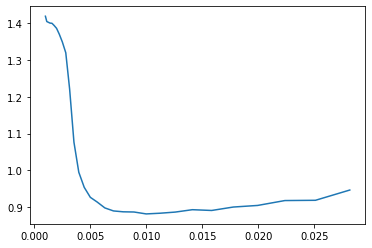

In [22]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

In [23]:
lr = 0.01

### Deep autorec crossval

In [26]:
import gc
tf.keras.backend.clear_session()
gc.collect()

2728

In [27]:
autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.01, patience=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) #tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, build_autorec_model, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 26s 402us/sample - loss: 1.3654 - mse_masked: 1.3563 - mape_masked: 0.3830 - mae: 0.8905 - val_loss: 1.4157 - val_mse_masked: 1.4069 - val_mape_masked: 0.4002 - val_mae: 0.9235
Epoch 2/15
64083/64083 [==============================] - 24s 375us/sample - loss: 1.1518 - mse_masked: 1.1421 - mape_masked: 0.3355 - mae: 0.7748 - val_loss: 1.4234 - val_mse_masked: 1.4159 - val_mape_masked: 0.3972 - val_mae: 0.9254
Epoch 3/15
64083/64083 [==============================] - 24s 375us/sample - loss: 1.0366 - mse_masked: 1.0289 - mape_masked: 0.3071 - mae: 0.7109 - val_loss: 1.4093 - val_mse_masked: 1.4030 - val_mape_masked: 0.3971 - val_mae: 0.9277
Epoch 4/15
64083/64083 [==============================] - 24s 376us/sample - loss: 0.8399 - mse_masked: 0.8338 - mape_masked: 0.2596 - mae: 0.5987 - val_loss: 1.4413 - val_mse_masked: 1.4355 - val_mape_masked: 0.3934 - val_mae: 0.9814
MSE: [1.380

66272/66272 [==============================] - 25s 370us/sample - loss: 1.1526 - mse_masked: 1.1448 - mape_masked: 0.3363 - mae: 0.7763 - val_loss: 1.5399 - val_mse_masked: 1.5286 - val_mape_masked: 0.4200 - val_mae: 1.0278
Epoch 3/15
66272/66272 [==============================] - 25s 376us/sample - loss: 0.9650 - mse_masked: 0.9582 - mape_masked: 0.2921 - mae: 0.6616 - val_loss: 1.6119 - val_mse_masked: 1.5999 - val_mape_masked: 0.4194 - val_mae: 1.0813
Epoch 4/15
66272/66272 [==============================] - 25s 374us/sample - loss: 0.7925 - mse_masked: 0.7865 - mape_masked: 0.2527 - mae: 0.5645 - val_loss: 1.5766 - val_mse_masked: 1.5666 - val_mape_masked: 0.4195 - val_mae: 1.0515
MSE: [1.3803223, 1.5631598, 1.3978754, 1.4327047, 1.2640737, 1.2136595, 1.4874158, 1.5028541]
Mape: [0.37228626, 0.397696, 0.38932565, 0.3874803, 0.34669363, 0.33078533, 0.38280225, 0.39736137]
Train on 66408 samples, validate on 2711 samples
Epoch 1/15
66408/66408 [==============================] - 27s 4

In [28]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [29]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

In [94]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [30]:
autorec_results.describe()

,autorec_mape,autorec_mse
count,10.000000,10.000000
mean,0.380144,1.433858
std,0.023671,0.121851
min,0.330785,1.213660
25%,0.374915,1.384711
50%,0.388403,1.460060
75%,0.397502,1.515482
max,0.399461,1.576820


In [52]:
autorec_model, mape, mse, autorec_history = conduct_experiment(crossvals[0], build_autorec_model, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 29s 446us/sample - loss: 1.3686 - mse_masked: 1.3588 - mape_masked: 0.3848 - mae: 0.8945 - val_loss: 1.4115 - val_mse_masked: 1.4042 - val_mape_masked: 0.4005 - val_mae: 0.9154
Epoch 2/15
64083/64083 [==============================] - 26s 412us/sample - loss: 1.1608 - mse_masked: 1.1536 - mape_masked: 0.3386 - mae: 0.7750 - val_loss: 1.4112 - val_mse_masked: 1.4049 - val_mape_masked: 0.4016 - val_mae: 0.9084
Epoch 3/15
64083/64083 [==============================] - 26s 410us/sample - loss: 1.0588 - mse_masked: 1.0524 - mape_masked: 0.3142 - mae: 0.7155 - val_loss: 1.4115 - val_mse_masked: 1.4062 - val_mape_masked: 0.3967 - val_mae: 0.9398
Epoch 4/15
64083/64083 [==============================] - 26s 404us/sample - loss: 0.9010 - mse_masked: 0.8955 - mape_masked: 0.2773 - mae: 0.6176 - val_loss: 1.4551 - val_mse_masked: 1.4505 - val_mape_masked: 0.3943 - val_mae: 0.9817


In [57]:
exd.test_records_selected.head(1).T

,1407
user_attr_Female,0
user_attr_Male,1
user_attr_missing,0
model_attr_Female,0
model_attr_Female&Male,0
...,...
split,0
rating,4
timestamp,2008-12-27
user_id,1038


In [102]:
pd.isna(exd.Xfeatures_train).any(), 

False

In [105]:
exd = crossvals[0]
xtest = [
        exd.test_records_selected.user_id.to_numpy(dtype='int32'),
        exd.test_records_selected.item_id.to_numpy(dtype='int32'),
        exd.test_records_selected.iloc[:, :-5].fillna(0.0).to_numpy(dtype='int32')
    ]

In [106]:
yhat = autorec_model.predict(xtest)
y = exd.test_records_selected.rating

In [108]:
tf.keras.metrics.mse(y_true=y, y_pred=yhat).numpy().mean()

1.5114853

In [115]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, yhat)

1.3614232321528639

In [119]:
tf.keras.metrics.mape(y, yhat).numpy().mean()

37.977783

# Compare two models

In [35]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative='two-sided')

WilcoxonResult(statistic=0.0, pvalue=0.005921537024148708)

In [42]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=3.0, pvalue=0.014432823938841786)

In [43]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse, use_continuity=True)

MannwhitneyuResult(statistic=34.0, pvalue=0.12066079650859002)

In [47]:
st.mannwhitneyu(autorec_results.autorec_mape, colab_res.colab_mape, use_continuity=True)

MannwhitneyuResult(statistic=35.0, pvalue=0.13651816987559418)

In [48]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=1.2142782525476903, pvalue=0.24247633853121428)

In [49]:
st.ttest_ind(autorec_results.autorec_mape, colab_res.colab_mape, equal_var=False)

Ttest_indResult(statistic=-0.8850882841976476, pvalue=0.38779487178451844)